# Red neuronal profunda para clasificación de imágenes

Usremos las funciones implementadas en el ejercicio anterior para construir una red neuronal profunda y aplicarla a una clasificación de imágenes (gato o no gato).


## 1 - Paquetes

- [numpy](https://www.numpy.org/) Paquete de cómputo científico.
- [matplotlib](http://matplotlib.org) Biblioteca para generar gráficos en Python.
- [h5py](http://www.h5py.org) Paquete para trabajar con bancos de datos en archivos h5.
- [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) usados para probar el modelo con tus propias imágenes
- dnn_app_utils es un arhivo con las funciones implementadas en el ejercicio anterior..

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

Usaremos el banco de datos llamado "catvnotcat"

**Enunciado del problea**: Se te provee de un banco de datos ("data.h5") que contiene:
    - un set de imágenes de entrenaminto con imágenes etiquetadas como gato (1) o no-gato(0)
    - un set de imágenes de prueba con imágenes etiquetadas como gato (1) o no-gato(0)
    - cada imágen es de la forma (num_px, num_px, 3) donde el 3 es por los 3 canales (RGB).


In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

El siguiente código muestra una imágen del banco de datos. Puedes cambiar el número del índice y volver a correr la celda para ver otras imágenes.

y = 1. It's a cat picture.


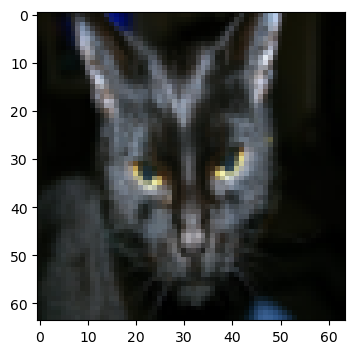

In [15]:
# Ejemplo de una imágen
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explorar el dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Numero de ejemplos de entrenamiento: " + str(m_train))
print ("Número de ejmplos de prueba: " + str(m_test))
print ("Cada imágen es de tamaño: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("forma de train_x_orig: " + str(train_x_orig.shape))
print ("forma de train_y: " + str(train_y.shape))
print ("forma de test_x_orig: " + str(test_x_orig.shape))
print ("forma de test_y: " + str(test_y.shape))

Numero de ejemplos de entrenamiento: 209
Número de ejmplos de prueba: 50
Cada imágen es de tamaño: (64, 64, 3)
forma de train_x_orig: (209, 64, 64, 3)
forma de train_y: (1, 209)
forma de test_x_orig: (50, 64, 64, 3)
forma de test_y: (1, 50)


Como siempre, es necesario ajustar y estandarizar la forma de las imágenes antes de introducirlas en la red. El código es el siguiente.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [5]:
# Dar forma a los datos
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # El -1 hace que la función aplane las dimensiones restantes
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Estandariza los valores para que queden entre 0 y 1.
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print ("forma de train_x: " + str(train_x.shape))
print ("forma de test_x: " + str(test_x.shape))


forma de train_x: (12288, 209)
forma de test_x: (12288, 50)


$12,288$ es igual $64 \times 64 \times 3$ que es el número de pixeles totales de la imagen multiplicado por los 3 canales.

## 3 - Arquitectura del modelo

Construiremos dos modelos diferentes:
- Una red neuronal de 2 capas.
- Una red neuronal profunda de L capas.

Posteriormnte compararemos el desempeño de estos dos modelos y probaremos diferentes valores para $L$. 

### 3.1 - Red neuronal de 2 capas

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: Red neuronal de dos capas. <br> El modelo se puede resumir como: ***Entrada -> LINEAR -> RELU -> LINEAR -> SIGMOID -> Salida***. </center></caption>

<u>Arquitectura detallada de la figura 2</u>:
- La entrada es una figura de 64 x 64 x 3 que queda aplanada a un vector de $(12288,1)$. 
- El vector correspondiente $[x_0,x_1,...,x_{12287}]^T$ se multiplica por la matriz de pesos $W^{[1]}$ de dimensiones $(n^{[1]}, 12288)$.
- S suma un término de "bias" y se calcula la función RELU para calcular el vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Rpetimos el mismo proceso.
- Multiplicamos el vector resultante por $W^{[2]}$ y agregamos el bias. 
- Finalment calculamos la función sigmoid del resultado. Si es mayor que 0.5, lo clasificamos como gato.

### 3.2 - Red neuronal de L capas.

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- La entrada es una imágen de (64,64,3) la cual es "aplanada" a un vector de (12288,1).
- El vector correspondiente: $[x_0,x_1,...,x_{12287}]^T$ es multiplicado por la matriz de pesos $W^{[1]}$ y luego se suma el "bias" $b^{[1]}$. El resultado es la unidad lineal.
- A continuación se calcula la función Relu de la función lineal. Este proceso se repite varias veces para cada capa $(W^{[l]}, b^{[l]})$ Dependiendo de la arquitectura del modelo.
- Finalmente se toma la función sigmoide de la unidad lineal de la última capa. Si el valor de la activación es mayor que 0.5, se clasifica como gato.

### 3.3 - Metodología general

Como siempre, seguiremos la metodología general para construir el modelo:
   - 1. inicializar los parámetros / Definir los hiperparámetros.
   - 2. Bucle que se repetirá un número de iteraciones (num_iterations) para el entrenamiento:
        - a. Propagación hacia adelante
        - b. Cálculo de la función costo
        - c. Propagación hacia atrás.
        - d. Actualización de parámetros (usando los gradientes de la propagación hacia atrás) 
   - 3. Usar los parámetros entrenados para predecir imágenes nuevas (test)

## 4 - Red neuronal de dos capas

Usa las funciones de ayuda implementadas en el ejercicio anterior para construir una red neuronal de 2 capas con la siguient eestructura: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Las funciones construidas y sus entradas son:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTES QUE DEFINEN EL MODELO ####
n_x = 12288     # num_px * num_px * 3, activaciones
n_h = 7         # numero de neuronas de las capas ocultas
n_y = 1         # numero de neuronas de la capa de salida
layers_dims = (n_x, n_h, n_y)

In [17]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implementa una red neuronal de dos capas: LINEAR->RELU->LINEAR->SIGMOID.
    
    Argumentos:
    X -- datos de entrada de la forma (n_x, número de ejemplos)
    Y -- vector de etiquetas verdaderas (contiene 1 si es un gato y 0 si no es un gato), de la forma (1, número de ejemplos)
    layers_dims -- dimensiones de las capas (n_x, n_h, n_y)
    num_iterations -- número de iteraciones del bucle de optimización
    learning_rate -- tasa de aprendizaje para la actualización de parámetros
    print_cost -- Variable para elegir si deseamos imprimir el costo cada 100 iteraciones
    
    Regresa:
    parameters -- un diccionario con W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Inicializa los parámetros del diccionario llamando a una de las funciones implementadas anteriormente
    ### INICIO ###
    
    ### FIN ###
    
    # Obtener W1, b1, W2 y b2 del diccionario de parámetros.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (descenso pro gradiente)

    for i in range(0, num_iterations):

        # Propagación hacia adelante: LINEAR -> RELU -> LINEAR -> SIGMOID. Entradas: "X, W1, b1, W2, b2". Salidas: "A1, cache1, A2, cache2".
        ### INICIO ###
        
        ### FIN ###
        
        # Calcular el costo
        ### INICIO ###
       
        ### FIN ###
        
        # Inicializar la propagación hacia atrás
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Propagación hacia atrás. Entradas: "dA2, cache2, cache1". Salidas: "dA1, dW2, db2 dA0 (sin usar), dW1, db1".
        ### INICIO ###
        
        ### FIN ###
        
        # Crear el diccionario de gradientes ['dWl'] a dW1, grads['db1'] a db1, grads['dW2'] a dW2, grads['db2'] a db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Actualizar parámetros.
        ### INICIO ###
        
        ### FIN ###

        # Recuperar W1, b1, W2, b2 de los parámetros
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Imprimir el costo cada 100 iteraciones
        if print_cost and i % 100 == 0:
            print("Costo después de la iteración {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteraciones (cada 100)')
    plt.title("Tasa de aprendizaje =" + str(learning_rate))
    plt.show()
    
    return parameters

Corre la siguiente celda para entrenar tus parámtros. Observa si el modelo corre. El costo debe empezar a disminuir. Puede tomar hasta 5 minutos correr 2500 iteraciones.  It may take up to 5 minutes to run 2500 iterations. Verifica si el "Costo depués de la iteración 0" es igual al de la salida esperada que se encuentra abajo, si no, haz click en el cuadro (⬛) en la barra superior para detener la celda y encontrar el error.

Costo después de la iteración 0: 0.6930497356599888
Costo después de la iteración 100: 0.6464320953428849
Costo después de la iteración 200: 0.6325140647912677
Costo después de la iteración 300: 0.6015024920354665
Costo después de la iteración 400: 0.5601966311605747
Costo después de la iteración 500: 0.515830477276473
Costo después de la iteración 600: 0.47549013139433266
Costo después de la iteración 700: 0.4339163151225749
Costo después de la iteración 800: 0.4007977536203887
Costo después de la iteración 900: 0.35807050113237976
Costo después de la iteración 1000: 0.3394281538366413
Costo después de la iteración 1100: 0.3052753636196264
Costo después de la iteración 1200: 0.27491377282130164
Costo después de la iteración 1300: 0.24681768210614854
Costo después de la iteración 1400: 0.19850735037466122
Costo después de la iteración 1500: 0.17448318112556638
Costo después de la iteración 1600: 0.1708076297809693
Costo después de la iteración 1700: 0.11306524562164713
Costo después de

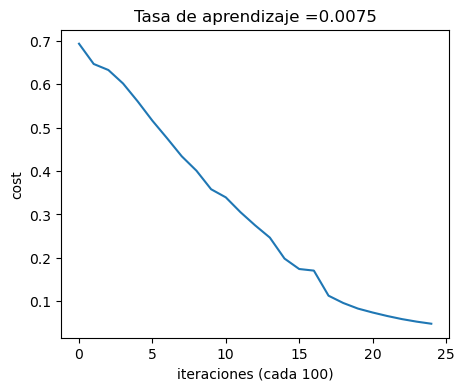

In [19]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770226 </td>
    </tr>
</table>

Ahora puedes utilizar los parámetros entrenados para clasificar imágenes del banco de datos. Para ver las predicciones en el banco de datos de entrenamiento y de predicción, corre la siguiente celda.

In [20]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [21]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Salida esperada**:

<table> 
    <tr>
        <td> **Precisión**</td>
        <td> 0.72 </td>
    </tr>
</table>

## 5 - Red neuronal de L capas

Usa las funciones de ayuda implementadas antes para construir un modelo de red neuronal de $L$-capas con la siguiente estructura: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Las funciones que usarás son:

```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### CONSTANTES ###
layers_dims = [12288, 20, 7, 5, 1] #  Modelo de 4 capas

In [ ]:

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implementa una red neuronal de L capas: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Argumentos:
    X -- datos de entrada de la forma (n_x, número de ejemplos)
    Y -- vector de etiquetas verdaderas (contiene 1 si es un gato y 0 si no es un gato), de la forma (1, número de ejemplos)
    layers_dims -- dimensiones de las capas (n_x, n_h, n_y)
    num_iterations -- número de iteraciones del bucle de optimización
    learning_rate -- tasa de aprendizaje para la actualización de parámetros
    print_cost -- Variable para elegir si deseamos imprimir el costo cada 100 iteraciones
    
    Regresa:
    parameters -- un diccionario con W1, W2, b1, and b2
    """

    np.random.seed(1)
    costs = []                         # mantiene un registro del costo
    
    # Inicialización de parámetros
    ### INICIO ###
    
    ### FIN ###
    
    # Loop (descenso por gradiente)
    for i in range(0, num_iterations):

        # Propagación hacia adelante: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### INICIO ###
        
        ### FIN ###
        
        # Calcular el costo.
        ### INICIO ###
        
        ### FIN ###
    
        # Propagación hacia atrás.
        ### INICIO  ###
        
        ### FIN ###
 
        # Actualizar parámetros.
        ### INICIO ###
        
        ### FIN ###
                
        # Imprimir el costo cada 100 iteraciones
        if print_cost and i % 100 == 0:
            print ("Costo después de la iteración %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # graficar el costo
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Ahora entrenaremos el modelo como una red neuronal de 4 capas. 

Corre la siguiente celda para entrenar tus parámtros. Observa si el modelo corre. El costo debe empezar a disminuir. Puede tomar hasta 5 minutos correr 2500 iteraciones.  It may take up to 5 minutes to run 2500 iterations. Verifica si el "Costo depués de la iteración 0" es igual al de la salida esperada que se encuentra abajo, si no, haz click en el cuadro (⬛) en la barra superior para detener la celda y encontrar el error.

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [ ]:
pred_test = predict(test_x, test_y, parameters)

**Salida esperada**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

##  6) Results Analysis

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

## 7) Prueba con tu propia imágen ##

In [ ]:
from PIL import Image

fileImage = Image.open("Cat03.jpg").convert("RGB").resize([num_px,num_px],Image.ANTIALIAS)
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

image = np.array(fileImage)
my_image = image.reshape(num_px*num_px*3,1)
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")